# Importing necessary libraries

In [1]:
%pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-o84qt_7y
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-o84qt_7y
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
import torchvision
from torchvision.datasets.flowers102 import Flowers102
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch import nn, optim
import clip
import random
import numpy as np
from PIL import Image
import copy
from itertools import chain

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 43

## Utility Functions

In [3]:
def base_novel_categories(dataset) -> tuple[list[int], list[int]]:
    # set returns the unique set of all dataset classes
    all_classes = set(dataset._labels)
    # and let's count them
    num_classes = len(all_classes)

    # here list(range(num_classes)) returns a list from 0 to num_classes - 1
    # then we slice the list in half and generate base and novel category lists
    base_classes = list(range(num_classes))[:num_classes // 2]
    novel_classes = list(range(num_classes))[num_classes // 2:]
    return base_classes, novel_classes


def harmonic_mean(base_accuracy, novel_accuracy):
    numerator = 2
    denominator = 1 / base_accuracy + 1 / novel_accuracy
    hm = numerator / denominator
    return hm


def get_data(data_dir='./data', transform=None) -> tuple[Flowers102,
                                                         Flowers102,
                                                         Flowers102]:
    """Load Flowers102 train, validation and test sets.
    Args:
        data_dir (str): Directory where the dataset will be stored.
        transform (torch.Compose)
    Returns:
        tuple: A tuple containing the train, validation, and test sets.
    """
    train = Flowers102(
        root=data_dir, split="train", download=True, transform=transform)
    val = Flowers102(
        root=data_dir, split="val", download=True, transform=transform)
    test = Flowers102(
        root=data_dir, split="test", download=True, transform=transform)
    return train, val, test


def split_data(dataset, base_classes):
    # these two lists will store the sample indexes
    base_categories_samples = []
    novel_categories_samples = []

    # we create a set of base classes to compute the test below in O(1)
    # this is optional and can be removed
    base_set = set(base_classes)

    # here we iterate over sample labels and also get the correspondent sample index
    for sample_id, label in enumerate(dataset._labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    # here we create the dataset subsets
    # the torch Subset is just a wrapper around the dataset
    # it simply stores the subset indexes and the original dataset (your_subset.dataset)
    # when asking for sample i in the subset, torch will look for its original position in the dataset and retrieve it
    # https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset
    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)
    return base_dataset, novel_dataset


def accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()


def train_one_epoch(
    model,
    dataloader,
    optimizer,
    base_indices,
):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for imgs, labels in tqdm(dataloader, desc="Training", leave=False):
        orig_imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # forward pass
        img_feats, txt_feats = model(orig_imgs.type(model.dtype))

        # compute logits
        logit_scale = model.logit_scale.exp()
        logits = logit_scale * img_feats @ txt_feats.t()
        logits_base = logits[:, base_indices]
        
        # CE loss on base classes only
        loss = F.cross_entropy(logits_base, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy(logits_base, labels)

    return total_loss / len(dataloader), total_acc / len(dataloader)


@torch.no_grad()
def eval(model, dataloader):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logit_scale = model.logit_scale.exp()
        img_feats, text_feats = model(images)
        logits = logit_scale * img_feats @ text_feats.t()
        loss = F.cross_entropy(logits, labels)

        total_loss += loss.item()
        total_acc += accuracy(logits, labels)

    return total_loss / len(dataloader), total_acc / len(dataloader)


def train_loop(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    base_indices,
    epochs=10,
    patience=3,
    model_state_path='adapter_weights.pt'
):
    best_val_acc = 0.0
    best_model_state = None
    epochs_no_improve = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch: {epoch}/{epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, base_indices)
        val_loss, val_acc = eval(model, val_loader)

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f"[LR] Current learning rate: {current_lr:.6f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc.: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc.: {val_acc:.4f}")

        # early stopping
        if patience < epochs:
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_ctx_state = copy.deepcopy(model.text_adapter.state_dict())
                torch.save(best_ctx_state, "ctx_state.pt")
                print(f"✅ New best model saved (val_acc = {best_val_acc:.4f})")
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                print(f"No improvement for {epochs_no_improve} epoch(s)")
            if epochs_no_improve >= patience:
                print(f"⏹️ Early stopping at epoch {epoch} (best val_acc = {best_val_acc:.4f})")
                break

    return history


# -- Reproducibility utils --

def set_seed(seed: int = 42):
    """
    Settings used for reproducibility purposes.
    https://pytorch.org/docs/stable/notes/randomness.html
    """
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)

    # Torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Torch determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"[INFO] Seed set to {seed}")


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


# Model Definition

### CLIP-Adapter

In [4]:
class TextAdapter(nn.Module):
    def __init__(self, classnames, clip_model, n_ctx=16):
        super(TextAdapter, self).__init__()
        self.classnames = classnames
        self.dtype = clip_model.dtype

        ctx_dim = clip_model.ln_final.weight.shape[0]  # context dimension
        self.ctx = nn.Parameter(torch.empty(n_ctx, ctx_dim))  # tokens to be learned
        nn.init.normal_(self.ctx, std=0.02)

        prompt_prefix = " ".join(['X'] * n_ctx)
        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        temp = 'a photo of a {}, a type of flower.'
        prompts = [temp.format(c) for c in classnames]
        prompts = [prompt_prefix + " " + p for p in prompts]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(DEVICE)

        with torch.no_grad():
            embeddings = clip_model.token_embedding(tokenized_prompts).type(self.dtype)

        # structure is: [BOS] [class tokens ... ] [EOS]
        self.register_buffer("token_prefix", embeddings[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embeddings[:, 1 + n_ctx :, :])  # class tokens + EOS
        self.tokenized_prompts = tokenized_prompts


    def forward(self, token_embeddings):
        # append the learnable context to the end of the token embeddings
        ctx = self.ctx.unsqueeze(0).expand(token_embeddings.shape[0], -1, -1)
        
        return torch.cat([
            self.token_prefix,  # BOS
            ctx,  # learned context
            self.token_suffix,  # class tokens + EOS
        ], dim=1).type(self.dtype)


### Custom CLIP

In [5]:
class CustomCLIP(nn.Module):
    def __init__(
        self,
        classnames: list[str],
        clip_model: nn.Module,
        text_adapter_args,
        text_adapter_state=None
    ):
        super().__init__()
        self.classnames = classnames
        self.dtype = clip_model.dtype
        self.clip_model = clip_model
        self.logit_scale = clip_model.logit_scale
        self.image_encoder = clip_model.visual

        # create and attach adapters
        self.text_adapter = TextAdapter(classnames, clip_model, **text_adapter_args)

        if text_adapter_state:
            self.text_adapter.load_state_dict(text_adapter_state)

    def encode_image(self, image):
        image_features = self.image_encoder(image.type(self.dtype))
        # norm & return
        return image_features / image_features.norm(dim=-1, keepdim=True)

    def encode_text_with_adapter(self): # CoOp
        text_embeddings = self.clip_model.token_embedding(
            self.text_adapter.tokenized_prompts).type(self.dtype)
        adapted_embeddings = self.text_adapter(text_embeddings)

        # pass through CLIP text transformer
        x = adapted_embeddings + self.clip_model.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.clip_model.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.clip_model.ln_final(x).type(self.dtype)

        text_features = x[
            torch.arange(x.shape[0]), self.text_adapter.tokenized_prompts.argmax(dim=-1)
            ] @ self.clip_model.text_projection
        return text_features / text_features.norm(dim=-1, keepdim=True)

    def encode_text_without_adapter(self):
        temp = 'a photo of a {}, a type of flower.'
        prompts = [temp.format(classname) for classname in self.classnames]
        prompts = torch.cat([clip.tokenize(p) for p in prompts])
        prompts = prompts.to(DEVICE)
        text_features = self.clip_model.encode_text(prompts)
        return text_features / text_features.norm(dim=-1, keepdim=True)

    def forward(self, images: torch.Tensor):
        # compute (normalized) text & image feats.
        image_features = self.encode_image(images.type(self.dtype))
        text_features = self.encode_text_with_adapter()
        return image_features, text_features

# Preparing the Dataset and CLIP

In [6]:
set_seed(SEED)

# Inspect classes
_, _, tmp_test = get_data()
base_classes, novel_classes = base_novel_categories(tmp_test)

CLASS_NAMES = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold',
    'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
    'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
    'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
    'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
    'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
    'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly',
    'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
    'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue',
    'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
    'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium',
    'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
    'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy',
    'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy',
    'gazania', 'azalea', 'water lily', 'rose', 'thorn apple',
    'morning glory', 'passion flower', 'lotus lotus', 'toad lily', 'anthurium',
    'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose',
    'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily',
    'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea',
    'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
    'trumpet creeper', 'blackberry lily'
]

# available models = ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
clip_model, preprocess = clip.load("ViT-B/16", device=DEVICE)

# get the three datasets
train_set, val_set, test_set = get_data(transform=preprocess)

# split classes into base and novel
base_classes, novel_classes = base_novel_categories(train_set)

# split the three datasets
train_base, _ = split_data(train_set, base_classes)
val_base, _ = split_data(val_set, base_classes)
test_base, test_novel = split_data(test_set, base_classes)

# Create data loaders
g = torch.Generator()
g.manual_seed(SEED)

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    train_base,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker
)

val_loader = torch.utils.data.DataLoader(
    val_base,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker
)

[INFO] Seed set to 43


# Preparing the custom Model + Training

In [7]:
epochs = 25
patience = 25
lr = 2e-3
wd = 1e-2

# CoOp hyperparam
n_ctx = 16
text_adapter_args = {"n_ctx": n_ctx}

coop = CustomCLIP(
    CLASS_NAMES,
    clip_model,
    text_adapter_args=text_adapter_args,
).to(DEVICE)

trainable_params = coop.text_adapter.parameters()

optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

history = train_loop(
    coop, train_loader, val_loader,
    optimizer, scheduler, epochs=epochs, patience=patience,
    base_indices=base_classes
)

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/25


[LR] Current learning rate: 0.001992
Train Loss: 1.0495 | Train Acc.: 0.7138
Val Loss: 1.0316 | Val Acc.: 0.7121

Epoch: 2/25


[LR] Current learning rate: 0.001969
Train Loss: 0.6541 | Train Acc.: 0.8096
Val Loss: 0.7386 | Val Acc.: 0.8003

Epoch: 3/25


[LR] Current learning rate: 0.001930
Train Loss: 0.4335 | Train Acc.: 0.8865
Val Loss: 0.6532 | Val Acc.: 0.8232

Epoch: 4/25


[LR] Current learning rate: 0.001876
Train Loss: 0.2954 | Train Acc.: 0.9296
Val Loss: 0.5009 | Val Acc.: 0.8680

Epoch: 5/25


[LR] Current learning rate: 0.001809
Train Loss: 0.2088 | Train Acc.: 0.9551
Val Loss: 0.4964 | Val Acc.: 0.8720

Epoch: 6/25


[LR] Current learning rate: 0.001729
Train Loss: 0.1537 | Train Acc.: 0.9727
Val Loss: 0.4154 | Val Acc.: 0.8880

Epoch: 7/25


[LR] Current learning rate: 0.001637
Train Loss: 0.1123 | Train Acc.: 0.9803
Val Loss: 0.4373 | Val Acc.: 0.8779

Epoch: 8/25


[LR] Current learning rate: 0.001536
Train Loss: 0.0975 | Train Acc.: 0.9824
Val Loss: 0.3774 | Val Acc.: 0.9116

Epoch: 9/25


[LR] Current learning rate: 0.001426
Train Loss: 0.0827 | Train Acc.: 0.9902
Val Loss: 0.3725 | Val Acc.: 0.9017

Epoch: 10/25


[LR] Current learning rate: 0.001309
Train Loss: 0.0768 | Train Acc.: 0.9841
Val Loss: 0.3346 | Val Acc.: 0.9135

Epoch: 11/25


[LR] Current learning rate: 0.001187
Train Loss: 0.0680 | Train Acc.: 0.9922
Val Loss: 0.3417 | Val Acc.: 0.9156

Epoch: 12/25


[LR] Current learning rate: 0.001063
Train Loss: 0.0541 | Train Acc.: 0.9958
Val Loss: 0.3298 | Val Acc.: 0.9135

Epoch: 13/25


[LR] Current learning rate: 0.000937
Train Loss: 0.0423 | Train Acc.: 0.9980
Val Loss: 0.3321 | Val Acc.: 0.9137

Epoch: 14/25


[LR] Current learning rate: 0.000813
Train Loss: 0.0362 | Train Acc.: 1.0000
Val Loss: 0.3157 | Val Acc.: 0.9156

Epoch: 15/25


[LR] Current learning rate: 0.000691
Train Loss: 0.0341 | Train Acc.: 1.0000
Val Loss: 0.3172 | Val Acc.: 0.9096

Epoch: 16/25


[LR] Current learning rate: 0.000574
Train Loss: 0.0328 | Train Acc.: 0.9961
Val Loss: 0.3126 | Val Acc.: 0.9116

Epoch: 17/25


[LR] Current learning rate: 0.000464
Train Loss: 0.0305 | Train Acc.: 0.9980
Val Loss: 0.3117 | Val Acc.: 0.9156

Epoch: 18/25


[LR] Current learning rate: 0.000363
Train Loss: 0.0269 | Train Acc.: 1.0000
Val Loss: 0.3108 | Val Acc.: 0.9117

Epoch: 19/25


[LR] Current learning rate: 0.000271
Train Loss: 0.0258 | Train Acc.: 1.0000
Val Loss: 0.3080 | Val Acc.: 0.9096

Epoch: 20/25


[LR] Current learning rate: 0.000191
Train Loss: 0.0245 | Train Acc.: 1.0000
Val Loss: 0.3096 | Val Acc.: 0.9096

Epoch: 21/25


[LR] Current learning rate: 0.000124
Train Loss: 0.0238 | Train Acc.: 1.0000
Val Loss: 0.3107 | Val Acc.: 0.9096

Epoch: 22/25


[LR] Current learning rate: 0.000070
Train Loss: 0.0233 | Train Acc.: 1.0000
Val Loss: 0.3099 | Val Acc.: 0.9116

Epoch: 23/25


[LR] Current learning rate: 0.000031
Train Loss: 0.0231 | Train Acc.: 1.0000
Val Loss: 0.3099 | Val Acc.: 0.9116

Epoch: 24/25


[LR] Current learning rate: 0.000008
Train Loss: 0.0228 | Train Acc.: 1.0000
Val Loss: 0.3099 | Val Acc.: 0.9116

Epoch: 25/25


[LR] Current learning rate: 0.000000
Train Loss: 0.0227 | Train Acc.: 1.0000
Val Loss: 0.3099 | Val Acc.: 0.9116


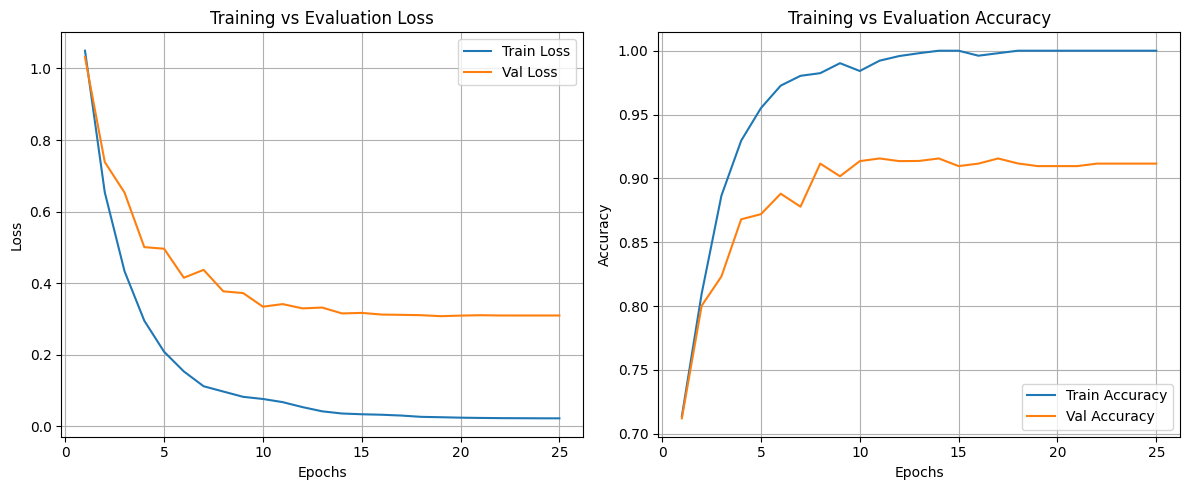

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Used as reference for plotting on the x-axis
x = range(1, len(history['train_loss']) + 1)

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(x, history['train_loss'], label='Train Loss')
plt.plot(x, history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(x, history['train_acc'], label='Train Accuracy')
plt.plot(x, history['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training vs Evaluation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation on best model found during training (based on validation accuracy)

In [9]:
# loading best saved model weights
text_adapter_state = torch.load("ctx_state.pt", weights_only=True)
best_model = CustomCLIP(
    CLASS_NAMES,
    clip_model,
    text_adapter_args,
    text_adapter_state=text_adapter_state  # learned ctx
).to(DEVICE)

# ---- Compute accuracy on base and novel classes ----
baseLoader = torch.utils.data.DataLoader(
    test_base,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)
novelLoader = torch.utils.data.DataLoader(
    test_novel,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)

print()
_, base_accuracy = eval(best_model, baseLoader)
print(f"🔍 Base classes accuracy: {base_accuracy*100:.2f}%")
_, novel_accuracy = eval(best_model, novelLoader)
print(f"🔍 Novel classes accuracy: {novel_accuracy*100:.2f}%")
print(f"🔍 Harmonic Mean: {harmonic_mean(base_accuracy, novel_accuracy)*100:.2f}%")

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



🔍 Base classes accuracy: 85.40%


🔍 Novel classes accuracy: 71.02%
🔍 Harmonic Mean: 77.55%


: 

# CoOp Analysis
The following code tries to assess how CoOp final textual features diverge from frozen CLIP's text encoder features and how that correlates with the performance of the model on both base and novel classes.

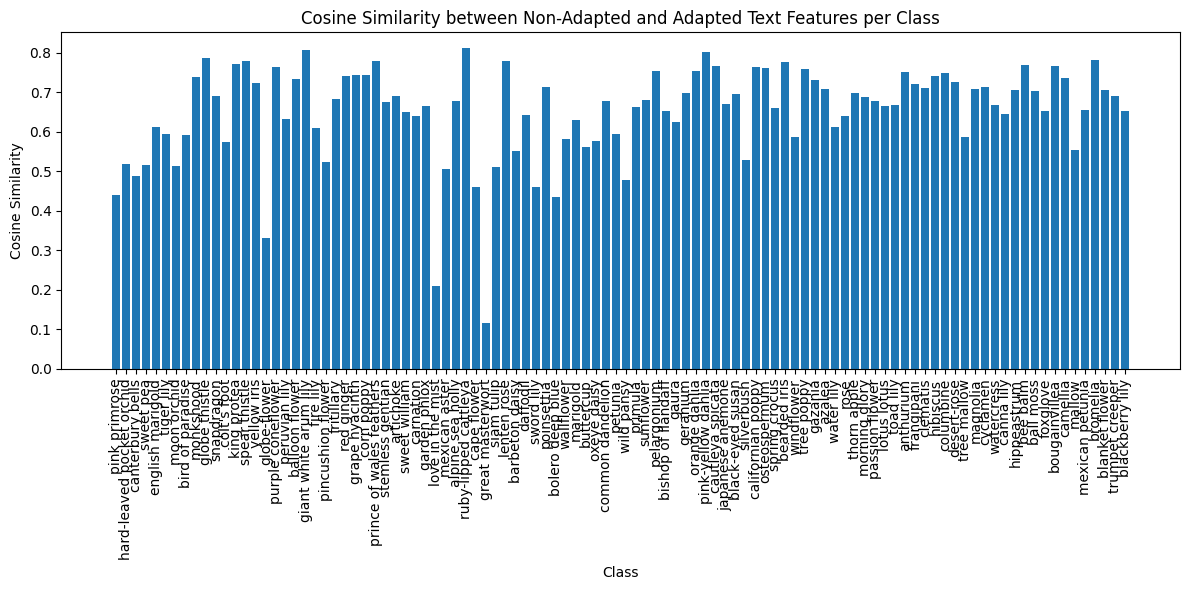

In [ ]:
def extract_text_features_and_metrics(model, dataloader, base_indices):
    model.eval()

    # extract text features once
    with torch.no_grad():
        # retrieve text features (adapted with CoOp and non-adapted i.e. CLIP frozen)
        non_adapted_text_features = model.encode_text_without_adapter() # shape: (num_classes, 512)
        adapted_text_features = model.encode_text_with_adapter() # shape: (num_classes, 512)

        # compute metrics
        cosine_similarities = F.cosine_similarity(non_adapted_text_features, adapted_text_features, dim=-1).cpu().numpy()

    # compute per-class accuracy and total counts for each of the 102 classes
    class_correct = np.zeros(len(class_names))
    class_total = np.zeros(len(class_names))

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Per-Class Evaluation"):
            images = images.to(device)
            labels = labels.to(device)

            img_features, text_features = model(images)
            
            logit_scale = model.logit_scale.exp()
            img_feats, text_feats = model(images)
            logits = logit_scale * img_feats @ text_feats.t() # shape: (batch_size, num_classes)

            predictions = logits.argmax(dim=-1) # shape: (batch_size)

            for pred in predictions:
                class_correct[pred] += 1
                class_total[pred] += 1
            

    return cosine_similarities
    
full_test_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([test_base, test_novel]),
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)
results = extract_text_features_and_metrics(best_model, None, None)